# Introduction to JumpStart - Object Detection

---
Welcome to Amazon [SageMaker JumpStart](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html)! You can use JumpStart to solve many Machine Learning tasks through one-click in SageMaker Studio, or through [SageMaker JumpStart API](https://sagemaker.readthedocs.io/en/stable/doc_utils/jumpstart.html). 

In this demo notebook, we demonstrate how to use the JumpStart API for Object Detection.  Object Detection refers to localizing objects in an image with a bounding box and predicting the classes of the objects. It can be used for counting objects, determining their exact locations and applied to multiple areas including security, surveillance, automated vehicle systems and machine inspection.

We demonstrate two use cases of object detection models:

* How to use pre-trained models trained on COCO dataset to do object detection.
* Use Jumpstart algorithm in transfer learning mode to train a Object Detection model on a custom dataset. 

---

1. [Set Up](#1.-Set-Up)
2. [Run inference on the pre-trained model](#2.-Run-inference-on-the-pre-trained-model)
    * [Select a pre-trained model for inference](#2.1.-Select-a-pre-trained-model-for-inference)
    * [Retrieve JumpStart Artifacts & Deploy an Endpoint](#2.2.-Retrieve-JumpStart-Artifacts-&-Deploy-an-Endpoint)
    * [Download an example image for inference](#2.3.-Download-an-example-image-for-inference)
    * [Query endpoint and parse response](#2.4.-Query-endpoint-and-parse-response)
    * [Display model predictions](#2.5.-Display-model-predictions)
    * [Clean up the endpoint](#2.6-Clean-up-the-endpoint)

3. [Fine-tune the pre-trained model on a custom dataset](#3.-Fine-tune-the-pre-trained-model-on-a-custom-dataset)
    * [Retrieve Training Artifacts](#3.1.-Retrieve-Training-Artifacts)
    * [Set Training hyperparameters](#3.2.-Set-Training-hyperparameters)
    * [Start the Training](#3.3.-Start-the-Training)
    * [Deploy and run inference on the fine-tuned model](#3.4.-Deploy-and-run-inference-on-the-fine-tuned-model)


Note: This notebook was tested in Amazon SageMaker Studio on ml.t3.medium instance with Python 3 (Data Science) kernel.


## 1. Set Up

---
Before executing the notebook, there are some initial steps required for setup. This notebook requires latest version of sagemaker and ipywidgets

---

In [57]:
!pip install sagemaker ipywidgets --upgrade --quiet

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


### Permissions and environment variables

---
To train and host on Amazon Sagemaker, we need to setup and authenticate the use of AWS services. Here, we use the execution role of the current notebook as the AWS account role with SageMaker access. It has necessary permissions, including access to your data in S3. 


* We need to identify the S3 bucket that you want to use for providing training and validation datasets. It will also be used to store the tranied model artifacts. In this notebook, we use a custom bucket. You could alternatively use a default bucket for the session. We use an object prefix to help organize the bucket content.
---

In [58]:
import sagemaker, boto3, json
from sagemaker import get_execution_role
from time import gmtime, strftime

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

output_bucket = sess.default_bucket()
output_prefix = "jumpstart-api-od-training-example"

## 2. Run inference on the pre-trained model

***

Using JumpStart, we can perform inference on the pre-trained base-model, even without fine-tuning it first on a new dataset. 
***

### 2.1. Select a pre-trained model for inference

***
Here, we download jumpstart model_manifest file from the jumpstart s3 bucket, and filter-out all the Object Detection models.
***

In [59]:
from ipywidgets import Dropdown

# download JumpStart model_manifest file.
boto3.client("s3").download_file(f"jumpstart-cache-prod-{aws_region}", "models_manifest.json", "models_manifest.json")
with open("models_manifest.json", "rb") as json_file: model_list = json.load(json_file)
    
# filter-out all the Object Detection models from the manifest list.
od_models = []
for model in model_list:
    model_id = model['model_id']
    if ("-od-" in model_id or "-od1-" in model_id) and model_id not in od_models:
        od_models.append(model_id)

print(f"Number of models available for inference: {len(od_models)}")
# display the model-ids in a dropdown, for user to select a model.
infer_model_dropdown = Dropdown(options=od_models, value="pytorch-od-nvidia-ssd", description='Chose a model for inference:', style={'description_width': 'initial'}, layout={'width': 'max-content'})
display(dropdown)

Number of models available for inference: 57


Dropdown(description='Chose a model for inference:', index=17, layout=Layout(width='max-content'), options=('m…

### 2.2. Retrieve JumpStart Artifacts & Deploy an Endpoint

***
We retrieve the base_model_uri for the pre-trained model, which is a model pre-trained on COCO 2017. We retrieve the deploy_image_uri, and the deploy_source_uri as well. To host the pre-trained base-model, we create an instance of [`sagemaker.model.Model`](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html) and deploy it.
***

In [60]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base

# model_version="*" fetches the latest version of the model
infer_model_id, infer_model_version = infer_model_dropdown.value, "*"


endpoint_name = name_from_base(f"jumpstart-api-infer-{infer_model_id}-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}")

inference_instance_type = "ml.p2.xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=infer_model_id,
    model_version=infer_model_version,
    instance_type=inference_instance_type,
)

# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=infer_model_id, 
    model_version=infer_model_version, 
    script_scope="inference"
)


# Retrieve the base model uri
base_model_uri = model_uris.retrieve(
    model_id=infer_model_id, 
    model_version=infer_model_version, 
    model_scope="inference"
)


# Create the SageMaker model instance
model = Model(
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    model_data=base_model_uri,
    entry_point="inference.py",
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name
)

# deploy the Model. Note that we need to pass Predictor class when we deploy model through Model class, 
# for being able to run inference through the sagemaker API.
base_model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
)

---------------!

### 2.3. Download an example image for inference
---
We download an example stored in an S3 bucket.

---

In [61]:
assets_s3_bucket = f"jumpstart-cache-prod-{aws_region}"
assets_key_prefix = "pytorch-metadata/assets"
Naxos_Taverna = "Naxos_Taverna.jpg"

boto3.client("s3").download_file(assets_s3_bucket, f"{assets_key_prefix}/{Naxos_Taverna}", Naxos_Taverna)

### 2.4. Query endpoint and parse response

In [62]:
import json

def query(model_predictor, image_file_name):
    with open(image_file_name, 'rb') as file: input_img_rb = file.read()

    query_response = model_predictor.predict(input_img_rb, {"ContentType":'application/x-image', "Accept":'application/json;verbose;n_predictions=3'})
    return query_response

def parse_response(model_predictions):
    model_predictions = json.loads(query_response)
    normalized_boxes, classes, scores, labels = model_predictions['normalized_boxes'], model_predictions['classes'], model_predictions['scores'], model_predictions['labels']
    # Substitute the classes index with the classes name
    class_names = [labels[int(idx)] for idx in classes]
    return normalized_boxes, class_names, scores

In [63]:
query_response = query(base_model_predictor, Naxos_Taverna)

normalized_boxes, classes_names, confidences = parse_response(query_response)

### 2.5. Display model predictions
---
We display the bounding boxes overlaid on the original image

---

In [64]:
import matplotlib.patches as patches
from matplotlib import pyplot as plt
from PIL import Image
from PIL import ImageColor
import numpy as np

def display_predictions(img_jpg, normalized_boxes, classes_names, confidences):
    colors = list(ImageColor.colormap.values())
    image_np = np.array(Image.open(img_jpg))
    plt.figure(figsize=(20,20))
    ax = plt.axes()
    ax.imshow(image_np)

    for idx in range(len(normalized_boxes)):
        left, bot, right, top = normalized_boxes[idx]
        x, w = [val * image_np.shape[1] for val in [left, right - left]]
        y, h = [val * image_np.shape[0] for val in [bot, top - bot]]
        color = colors[hash(classes_names[idx]) % len(colors)]
        rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_names[idx], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))

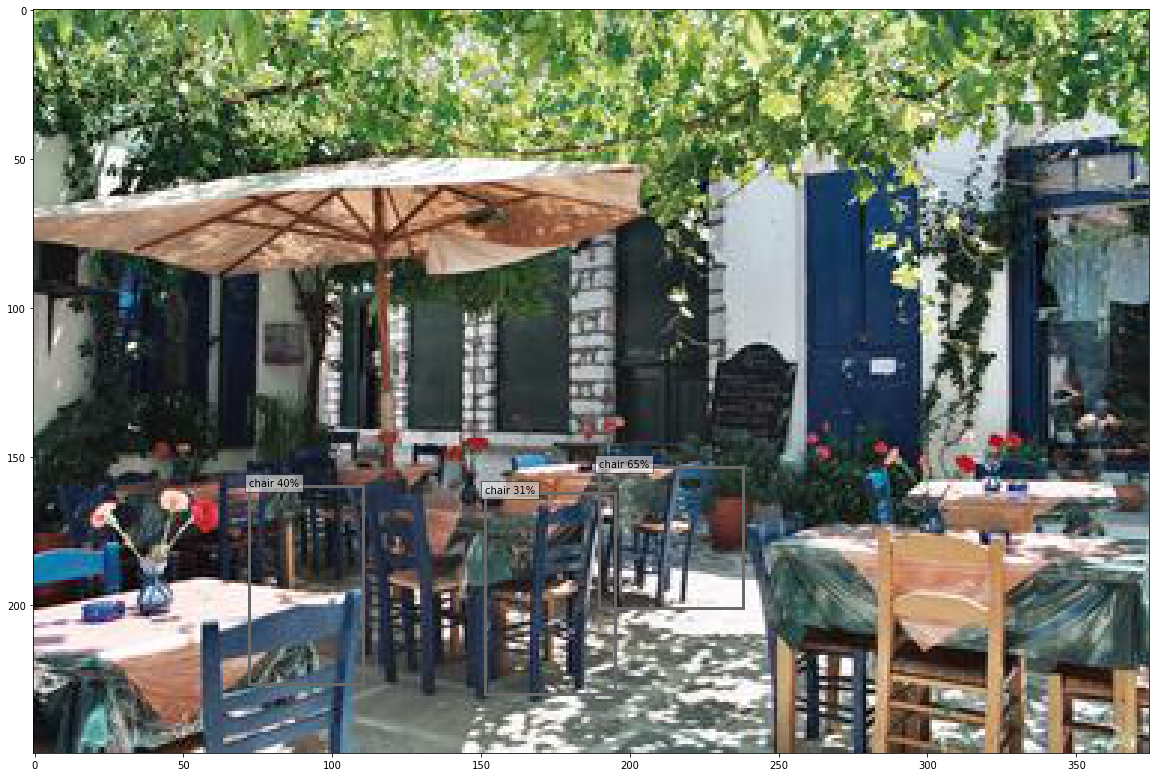

In [65]:
display_predictions(Naxos_Taverna, normalized_boxes, classes_names, confidences)

### 2.6. Clean up the endpoint

In [66]:
# Delete the SageMaker endpoint
base_model_predictor.delete_endpoint()

## 3. Fine-tune the pre-trained model on a custom dataset

Previously, we saw how to run inference on a pre-trained model. Next, we discuss how this model can be finetuned to a custom dataset with any number of classes. 

Transfer learning algorithm removes the object detection head of the pre-trained model and attaches a head with number of classes same as the custom dataset. The fine-tuning step fine-tunes the last layer parameters while keeping the parameters of the rest of the model frozen, and returns the fine-tuned model. The objective is to minimize box prediction error on the input data. 

Input must be a directory with sub-directoriey images and a file annotations.json. The input directory should look like below if the training data contains two images. Note the trailing `/` is required. The names of .png files
can be anything. 

    input_directory
        |--images
            |--abc.png
            |--def.png
        |--annotations.json
            
 
The annotations.json file should should have information for bounding_boxes and their class labels. It should have a 
dictionary with keys "images" and "annotations". Value for the "images" key should be a list of entries, 
one for each image of the form {"file_name": image_name, "height": height, "width": width, "id": image_id}. Value of the 'annotations' key should be a list of entries, one for each bounding box of the form {"image_id": image_id, "bbox": \[xmin, ymin, xmax, ymax\], "category_id": bbox_label}.

We provide pennfudanped dataset as a default dataset for fine-tuning the model.
PennFudanPed comprises images of pedestrians. The dataset has been downloaded from [here](https://www.cis.upenn.edu/~jshi/ped_html/#pub1). 

Citation:
<sub><sup>
@ONLINE {pennfudanped,
author = "Liming Wang1, Jianbo Shi2, Gang Song2, and I-fan Shen1",
title = "Penn-Fudan Database for Pedestrian Detection and Segmentation",
year = "2007",
url = "https://www.cis.upenn.edu/~jshi/ped_html/" }
</sup></sub>

### 3.1. Retrieve Training Artifacts

Here, for the selected model, we retrieve the training docker container, the training algorithm source, the pre-trained base model, and a python dictionary of the training hyper-parameters that the algorithm accepts with their default values. Note that, model_version="*" fetches the lates model.

In [67]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters

# Currently, not all the object detection models in jumpstart support finetuning. Thus, we manually select a model
# which supports finetuning. 
train_model_id, train_model_version, train_scope = "mxnet-od-ssd-300-vgg16-atrous-coco", "*", "training"
training_instance_type = "ml.p2.xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None, 
    framework=None,
    model_id=train_model_id, 
    model_version=train_model_version, 
    image_scope=train_scope, 
    instance_type=training_instance_type, 
)
# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, 
    model_version=train_model_version, 
    script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, 
    model_version=train_model_version, 
    model_scope=train_scope
)
# Retrieve the default hyper-parameters for fine-tuning the model
default_hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, 
    model_version=train_model_version
)

### 3.2. Set Training hyperparameters

Now that we are done with all the setup that is needed, we are ready to train our Object Detection model. To begin, let us create a [``sageMaker.estimator.Estimator``](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) object. This estimator will launch the training job.
### Training parameters
There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include:

* **Training instance type**: This indicates the type of machine on which to run the training. Typically, we use GPU instances for these training 
* **Output path**: This the s3 folder in which the training output is stored

The second ones are algorithm specific training hyper-parameters. The can be looked into the `default_hyperparameters` dictionary, and overridden to custom values.

In [68]:
s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

# [Optional] Override default hyperparameters with custom values
default_hyperparameters["epochs"] = "10"
print(default_hyperparameters)

{'epochs': '10', 'adam-learning-rate': '0.01', 'batch-size': '4'}


In [69]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base

training_job_name = name_from_base(f"jumpstart-api-{train_model_id}-transfer-learning-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}")

# Create SageMaker Estimator instance
od_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=default_hyperparameters,
    output_path=s3_output_location,
)

### 3.3. Start the Training

In [ ]:
# Sample training data is available in this bucket
training_data_bucket = f"jumpstart-cache-prod-{aws_region}"
training_data_prefix = "training-datasets/PennFudanPed_COCO_format/"

training_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}"

# Launch a SageMaker Training job by passing s3 path of the training data
od_estimator.fit({"training": training_dataset_s3_path}, logs=True)

2022-03-07 00:51:50 Starting - Starting the training job...ProfilerReport-1646614309: InProgress
...
2022-03-07 00:52:34 Starting - Preparing the instances for training......
2022-03-07 00:53:42 Downloading - Downloading input data...
2022-03-07 00:54:15 Training - Downloading the training image............
2022-03-07 00:56:16 Training - Training image download completed. Training in progress..2022-03-07 00:56:12,265 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2022-03-07 00:56:12,297 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"adam-learning-rate":0.01,"batch-size":4,"epochs":10}', 'SM_USER_ENTRY_POINT': 'transfer_learning.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_group_name":"homogeneousCluster","current_host":"algo-1","current_instance_type":"ml.p2.xlarge","hosts":["algo-1"],"instance_groups":[{"hosts":["algo-1"

### 3.4. Deploy and run inference on the fine-tuned model

---

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the bounding boxes of an image. We follow the same steps as in [2. Run inference on the pre-trained model](#2.-Run-inference-on-the-pre-trained-model).

We start by retrieving the jumpstart artifacts for deploying an endpoint. However, instead of base_predictor, we  deploy the `od_estimator` that we fine-tuned.

---

In [ ]:
inference_instance_type = "ml.p2.xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, 
    model_version=train_model_version, 
    script_scope="inference"
)

endpoint_name = name_from_base(f"sagemaker-api-{train_model_id}-FT-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}")
# Use the estimator from the previous step to deploy to a SageMaker endpoint
finetuned_predictor = od_estimator.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)

In [ ]:
print(finetuned_predictor)

---
Next, we download an example pedestrian image from the S3 bucket for inference.

---

In [ ]:
pedestrian_image_s3_bucket = f"jumpstart-cache-prod-{aws_region}"
pedestrian_image_key = "training-datasets/PennFudanPed_COCO_format/images"
pedestrian_image_file_name = "FudanPed00001.png"

boto3.client("s3").download_file(pedestrian_image_s3_bucket, f"{pedestrian_image_key}/{pedestrian_image_file_name}", pedestrian_image_file_name)

---
Next, we query the finetuned model, parse the response and display the predictions. Funtions for these are implemented in sections [2.4. Query endpoint and parse response](#2.4.-Query-endpoint-and-parse-response) and [2.5. Display model predictions](#2.5.-Display-model-predictions)

---

In [ ]:
query_response = query(finetuned_predictor, pedestrian_image_file_name)

normalized_boxes, classes_names, confidences = parse_response(query_response)
display_predictions(pedestrian_image_file_name, normalized_boxes, classes_names, confidences)

---
Next, we delete the endpoint corresponding to the finetuned model.

---

In [ ]:
# Delete the SageMaker endpoint
finetuned_predictor.delete_endpoint()